In [2]:
import sys
sys.path.append("../../src")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from example_lorenz import generate_lorenz_data
import os
import pickle
from autoencoder import FullNetwork
import torch
from sindy_utils import sindy_simulate

data_path = os.getcwd() + '\\lorenz_model_1\\'
save_name = 'lorenz_2024_04_07_23_29_11_426420'
params = pickle.load(open(data_path + save_name + '_params.pkl', 'rb'))
params['save_name'] = data_path + save_name
dataframe = pd.read_pickle(data_path + 'experiment_results_202404080247.pkl')


Xi_plot = np.array(dataframe['coefficient_mask']*dataframe['sindy_coefficients'])[0]
sindy_coefficients = np.array(dataframe['sindy_coefficients'])[0]
coefficient_mask = np.array(dataframe['coefficient_mask'])[0]
   

In [3]:
autoencoder_network = FullNetwork(params).to(params['device'])
path = data_path + 'lorenz_2024_04_07_23_29_11_426420.pth'
state_dict = torch.load(path)
autoencoder_network.load_state_dict(state_dict)


<All keys matched successfully>

In [4]:
t = np.arange(0,20,.01)
z0 = np.array([[-8,7,27]])

test_data = generate_lorenz_data(z0, t, params['input_dim'], linear=False, normalization=np.array([1/40,1/40,1/40]))
test_data['x'] = torch.tensor(test_data['x'].reshape((-1,params['input_dim'])), dtype=torch.float32).to(params['device'])
test_data['dx'] = torch.tensor(test_data['dx'].reshape((-1,params['input_dim'])), dtype=torch.float32).to(params['device'])
test_data['z'] = test_data['z'].reshape((-1,params['latent_dim']))
test_data['dz'] = test_data['dz'].reshape((-1,params['latent_dim']))

In [5]:
a1 = 1
a2 = test_data['sindy_coefficients'][2, 0]/sindy_coefficients[2,0]
a3 = np.sqrt(-sindy_coefficients[5,2]/sindy_coefficients[6,1]*a2**2)
b3 = -sindy_coefficients[0,2]/sindy_coefficients[3,2]

sindy_coefficients_transformed = np.zeros(sindy_coefficients.shape)
sindy_coefficients_transformed[1,0] = sindy_coefficients[1,0]
sindy_coefficients_transformed[2,0] = sindy_coefficients[2,0]*a2/a1
sindy_coefficients_transformed[1,1] = sindy_coefficients[6,1]*a1/a2*b3
sindy_coefficients_transformed[2,1] = sindy_coefficients[2,1]
sindy_coefficients_transformed[6,1] = sindy_coefficients[6,1]*a1*a3/a2
sindy_coefficients_transformed[3,2] = sindy_coefficients[3,2]
sindy_coefficients_transformed[5,2] = sindy_coefficients[5,2]*a1*a2/a3

In [6]:
_, _, _, test_results_z, _, _, _, _ = autoencoder_network.forward(test_data['x'], test_data['dx'])
test_results_z = test_results_z.cpu().detach().numpy()

z0_transformed = np.array([test_results_z[0,0]/a1,
                           test_results_z[0,1]/a2,
                           (test_results_z[0,2] - b3)/a3])

In [7]:
z_sim = sindy_simulate(test_results_z[0], t, coefficient_mask*sindy_coefficients,
                       params['poly_order'], params['include_sine'])

z_sim_transformed = sindy_simulate(z0_transformed, t, sindy_coefficients_transformed,
                                      params['poly_order'], params['include_sine'])

lorenz_sim = sindy_simulate(test_data['z'][0], t, test_data['sindy_coefficients'],
                            params['poly_order'], params['include_sine'])


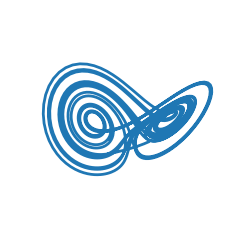

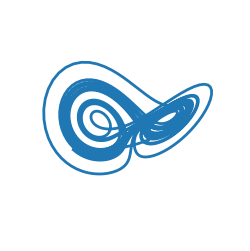

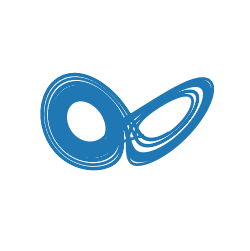

In [8]:
fig1 = plt.figure(figsize=(3,3))
ax1 = fig1.add_subplot(111, projection='3d')
ax1.plot(z_sim[:,0], z_sim[:,1], z_sim[:,2], linewidth=2)
plt.axis('off')
ax1.view_init(azim=120)
plt.show()
fig1.savefig('lorenz_sim_lr=1e-3.png')

fig2 = plt.figure(figsize=(3,3))
ax2 = fig2.add_subplot(111, projection='3d')
ax2.plot(z_sim_transformed[:,0], z_sim_transformed[:,1], z_sim_transformed[:,2], linewidth=2)
plt.axis('off')
ax2.view_init(azim=120)
plt.show()
fig2.savefig('lorenz_sim_lr=1e-3_transformed.png')

fig3 = plt.figure(figsize=(3,3))
ax3 = fig3.add_subplot(111, projection='3d')
ax3.plot(lorenz_sim[:,0], lorenz_sim[:,1], lorenz_sim[:,2], linewidth=2)
plt.xticks([])
plt.axis('off')
fig3.savefig('lorenz_sim_ground_truth.png')
ax3.view_init(azim=120)

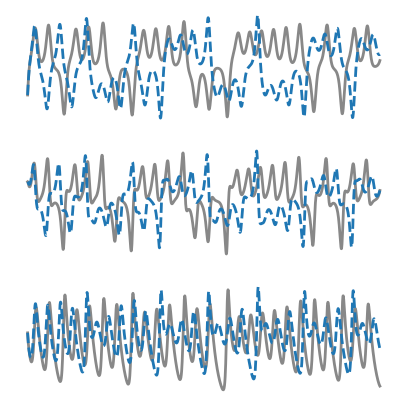

In [9]:
plt.figure(figsize=(5,5))
for i in range(3):
    plt.subplot(3,1,i+1)
    plt.plot(t, test_results_z[:,i], color='#888888', linewidth=2)
    plt.plot(t, z_sim[:,i], '--', linewidth=2)
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')

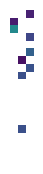

[[-0.         -0.         -6.1871023 ]
 [-6.90075    -0.         -0.        ]
 [ 8.877033   -0.          0.        ]
 [ 0.         -0.         -1.5605378 ]
 [ 0.         -0.          0.        ]
 [ 0.          0.          2.4119394 ]
 [-0.         -8.196304    0.        ]
 [-0.         -0.          0.11464713]
 [ 0.         -0.21290408  0.        ]
 [ 0.         -0.         -0.        ]
 [-0.         -0.         -0.        ]
 [-0.         -0.          0.        ]
 [-0.         -0.          0.        ]
 [-0.         -0.         -0.        ]
 [ 0.         -0.          0.        ]
 [-0.         -0.21197131  0.        ]
 [ 0.         -0.         -0.        ]
 [ 0.         -0.          0.        ]
 [ 0.         -0.          0.        ]
 [ 0.         -0.         -0.        ]]


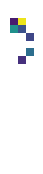

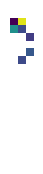

In [11]:

Xi_plot = np.where(Xi_plot == 0, np.inf, Xi_plot)
fig_sindy1 = plt.figure(figsize=(1,2))
plt.imshow(Xi_plot, interpolation='none')
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.clim([-10,30])
plt.show()
fig_sindy1.savefig('sindy_coefficients_lr=1e-3.png')
print(coefficient_mask*sindy_coefficients)

Xi_transformed_plot = np.copy(sindy_coefficients_transformed)
Xi_transformed_plot[Xi_transformed_plot==0] = np.inf
fig_sindy2 = plt.figure(figsize=(1,2))
plt.imshow(Xi_transformed_plot, interpolation='none')
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.clim([-10,30])
plt.show()
fig_sindy2.savefig('sindy_coefficients_lr=1e-3_transformed.png')

Xi_true_plot = np.copy(test_data['sindy_coefficients'])
Xi_true_plot[Xi_true_plot==0] = np.inf
Xi_true_plot[6,1] = -1.
Xi_true_plot[5,2] = 1.
plt.figure(figsize=(1,2))
plt.imshow(Xi_true_plot, interpolation='none')
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.clim([-10,30])
plt.savefig('sindy_coefficients_ground_truth.png')